In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
from courtvision.data import (
    PadelDataset,
    get_keypoints_as_dict,
    CourtVisionDataset,
    dict_to_points,
)
from courtvision.vis import draw_rect, load_image, draw_points, plot_3d_points
from courtvision.geometry import corners_world_3d, convert_obj_points_to_planar
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
CALIBRATION_DATA_PATH = Path(
    "/Users/benjamindecharmoy/projects/courtvision/datasets/calibrations/v1/project-1-at-2023-06-05-11-03-246a0246.json"
)
DATA_ROOT = Path(
    "/Users/benjamindecharmoy/projects/courtvision/courtvision_balldetector/data/labelstudiodata/media"
)

In [4]:
with open(CALIBRATION_DATA_PATH, "r") as fp:
    calibration_keypoints = PadelDataset(samples=json.load(fp))

image = load_image(
    CourtVisionDataset.find_image_path(
        DATA_ROOT, sample=calibration_keypoints.samples[0]
    )
)

['a_front_left', 'b_front_right', 'c_back_left', 'd_back_right', 'e_left_near_serve_line', 'f_right_near_serve_line', 'g_left_far_serve_line', 'h_right_far_serve_line', 'i_center_line_far', 'j_net_line_left', 'k_center_line_near', 'l_net_line_right', 'm_top_front_left', 'n_top_front_right', 'o_top_back_left', 'p_top_back_right', 'q_top_net_line_left', 'r_top_net_line_right', 's_top_net_center', 't_center_center', 'u_topfence_front_left', 'v_topfence_front_right', 'w_topfence_back_left', 'x_topfence_back_right', 'y_top_center_left', 'z_top_center_right']


(<matplotlib.image.AxesImage at 0x108dcffd0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

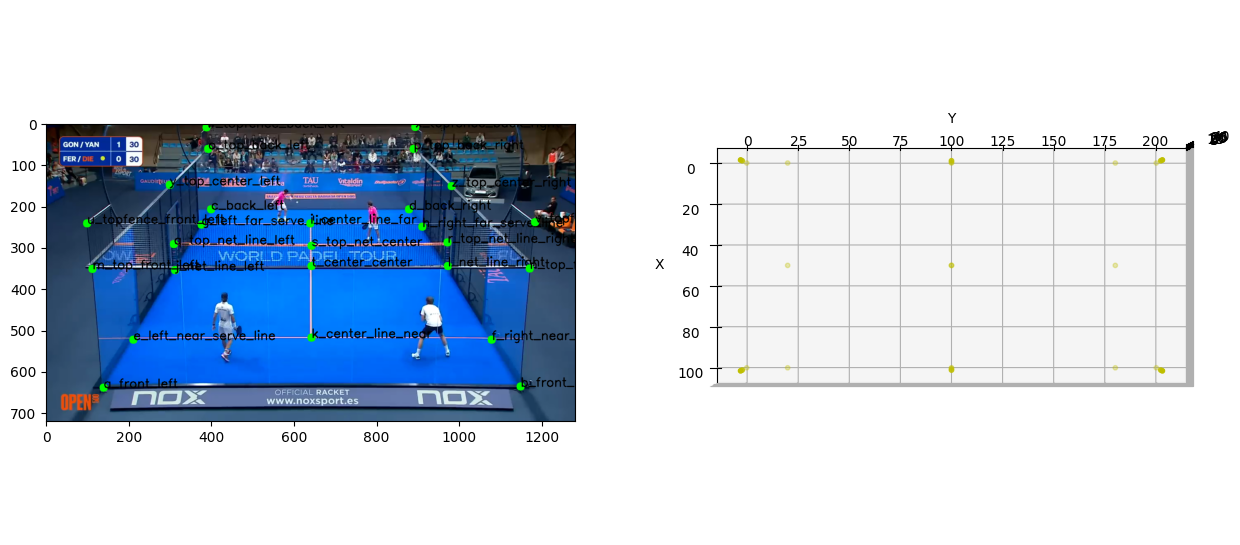

In [5]:
keypoint_dict = get_keypoints_as_dict(
    calibration_keypoints.samples[0].annotations[0].result
)
world_points, world_labels = dict_to_points(corners_world_3d)
keypoints, labels = dict_to_points(keypoint_dict)
assert all([l1 == l2 for l1, l2 in zip(labels, world_labels)])
print(labels)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(draw_points(image.copy(), keypoints, labels=labels)), plot_3d_points(
    x=world_points[:, 0], y=world_points[:, 1], z=world_points[:, 2], plt_axis=ax2
)

['a_front_left',
 'b_front_right',
 'e_left_near_serve_line',
 'k_center_line_near']

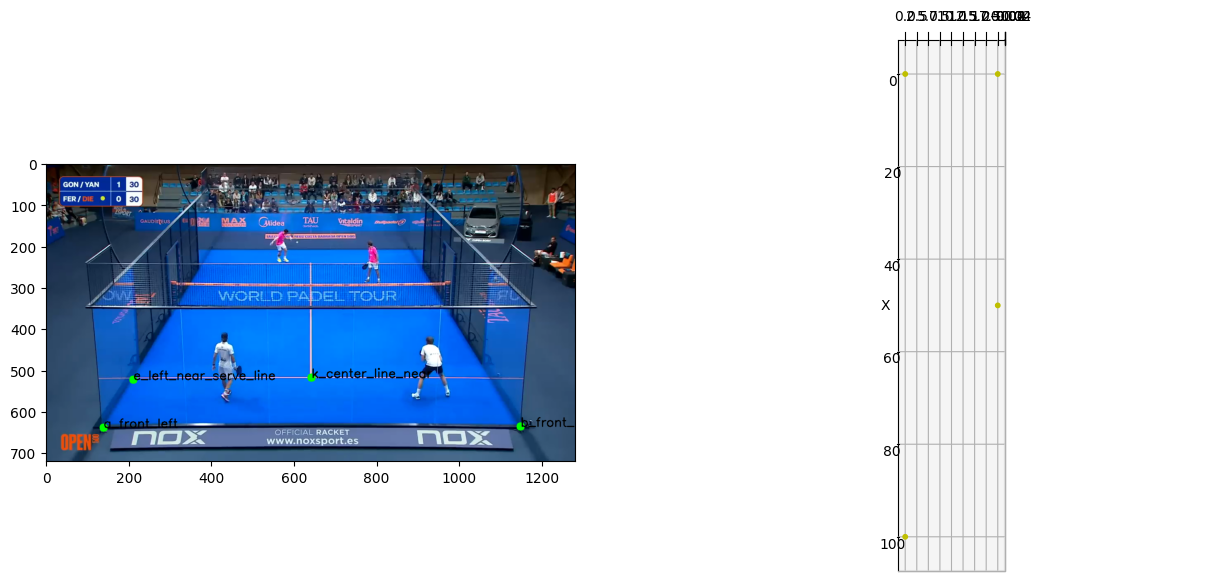

In [6]:
#  Group points into common horizontal planes
f = lambda k: "top" not in k and k in [
    "a_front_left",
    "b_front_right",
    "e_left_near_serve_line",
    "k_center_line_near",
]
floor_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if f(k))
floor_plane_world_dict = dict((k, v) for k, v in corners_world_3d.items() if f(k))
floor_plane_world_points, floor_plane_world_labels = dict_to_points(
    floor_plane_world_dict
)
floor_plane_keypoints, floor_plane_labels = dict_to_points(floor_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), floor_plane_keypoints, labels=floor_plane_labels)
), plot_3d_points(
    x=floor_plane_world_points[:, 0],
    y=floor_plane_world_points[:, 1],
    z=floor_plane_world_points[:, 2],
    plt_axis=ax2,
)
floor_plane_labels

(<matplotlib.image.AxesImage at 0x2ae96b210>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

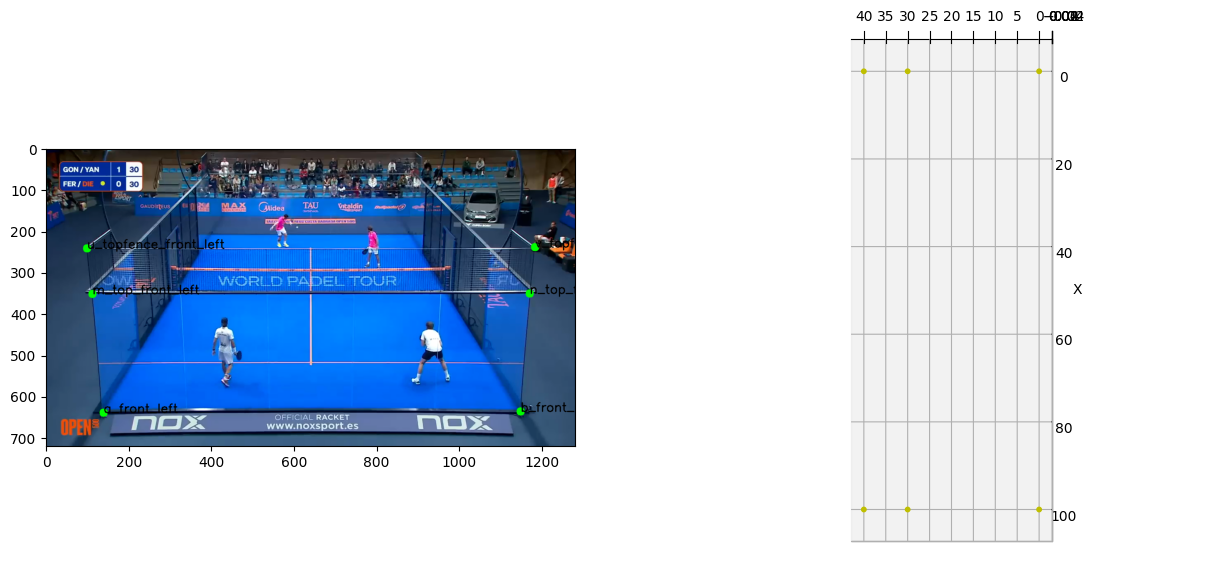

In [7]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
front_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "front" in k)
front_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "front" in k
)
front_wall_plane_world_points, front_wall_plane_world_labels = dict_to_points(
    front_wall_plane_world_dict
)
front_wall_plane_keypoints, front_wall_plane_labels = dict_to_points(
    front_wall_plane_dict
)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(
        image.copy(), front_wall_plane_keypoints, labels=front_wall_plane_labels
    )
), plot_3d_points(
    x=front_wall_plane_world_points[:, 0],
    y=front_wall_plane_world_points[:, 1],
    z=front_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 90),
)

(<matplotlib.image.AxesImage at 0x2af68fd10>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

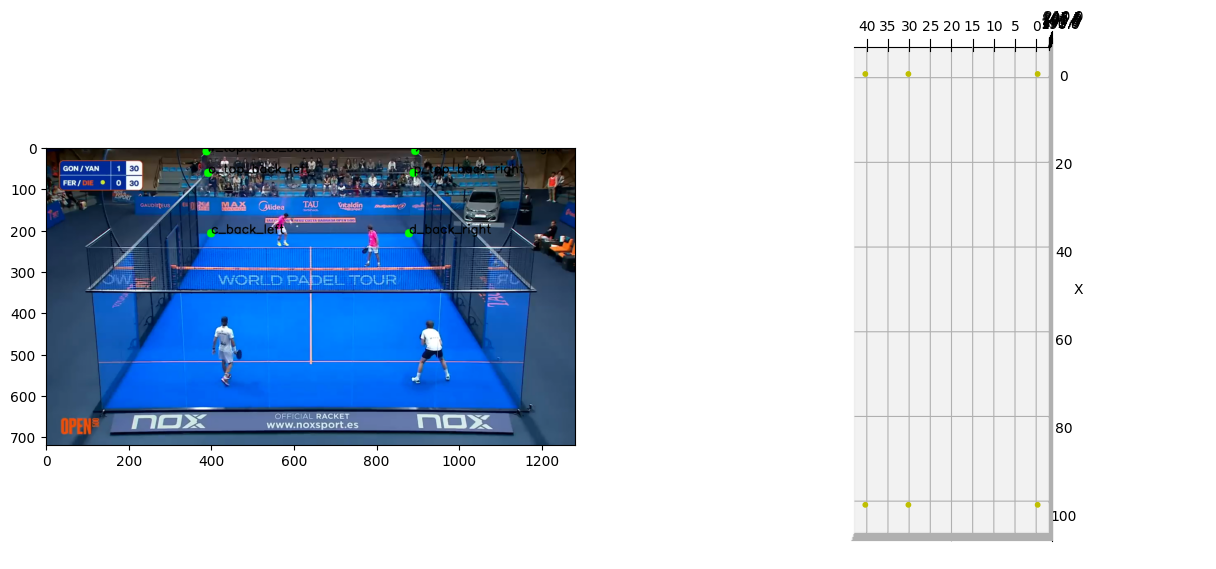

In [8]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
back_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "back" in k)
back_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "back" in k
)
back_wall_plane_world_points, back_wall_plane_world_labels = dict_to_points(
    back_wall_plane_world_dict
)
back_wall_plane_keypoints, back_wall_plane_labels = dict_to_points(back_wall_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), back_wall_plane_keypoints, labels=back_wall_plane_labels)
), plot_3d_points(
    x=back_wall_plane_world_points[:, 0],
    y=back_wall_plane_world_points[:, 1],
    z=back_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 90),
)

(<matplotlib.image.AxesImage at 0x2af8a3210>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

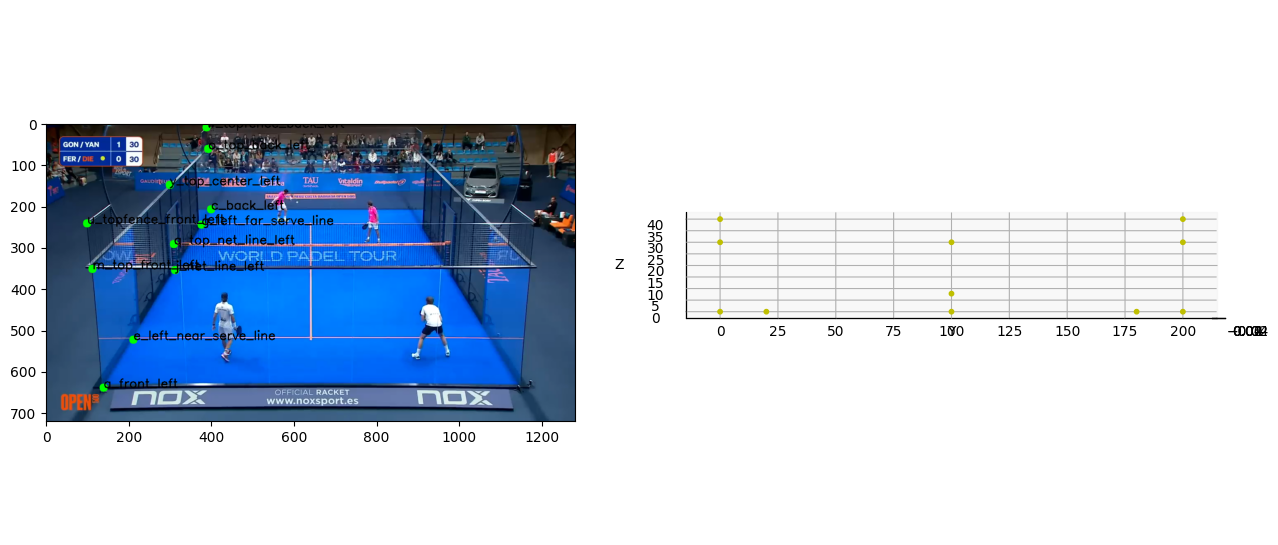

In [9]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
left_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "left" in k)
left_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "left" in k
)
left_wall_plane_world_points, left_wall_plane_world_labels = dict_to_points(
    left_wall_plane_world_dict
)
left_wall_plane_keypoints, left_wall_plane_labels = dict_to_points(left_wall_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), left_wall_plane_keypoints, labels=left_wall_plane_labels)
), plot_3d_points(
    x=left_wall_plane_world_points[:, 0],
    y=left_wall_plane_world_points[:, 1],
    z=left_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 0, 0),
)

(<matplotlib.image.AxesImage at 0x2afa20990>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

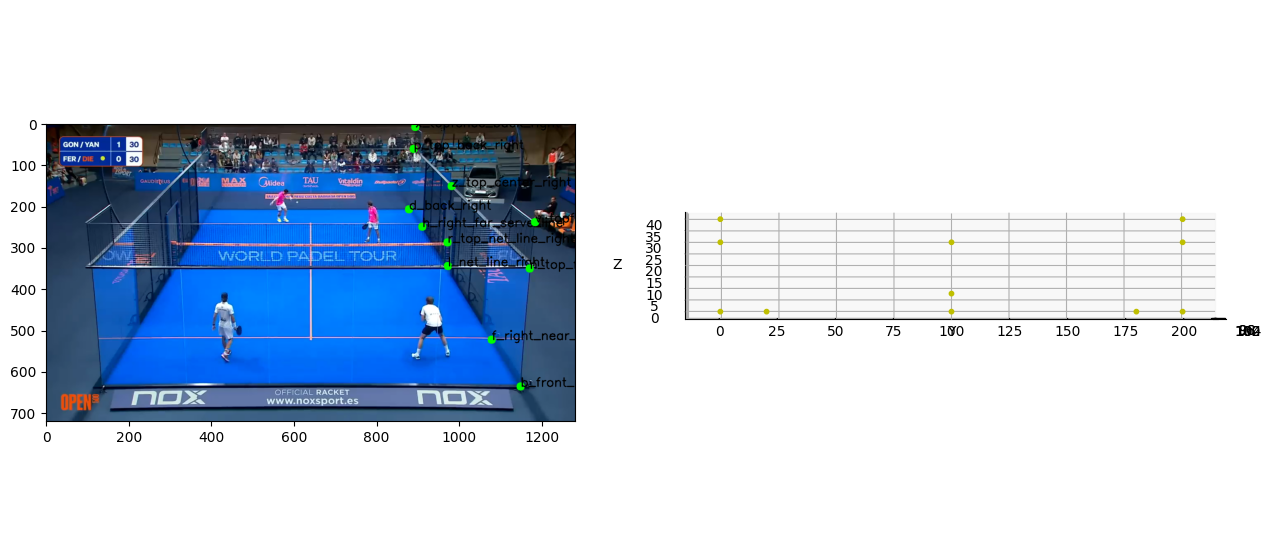

In [10]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
right_wall_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "right" in k)
right_wall_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "right" in k
)
right_wall_plane_world_points, right_wall_plane_world_labels = dict_to_points(
    right_wall_plane_world_dict
)
right_wall_plane_keypoints, right_wall_plane_labels = dict_to_points(
    right_wall_plane_dict
)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(
        image.copy(), right_wall_plane_keypoints, labels=right_wall_plane_labels
    )
), plot_3d_points(
    x=right_wall_plane_world_points[:, 0],
    y=right_wall_plane_world_points[:, 1],
    z=right_wall_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 0, 0),
)

(<matplotlib.image.AxesImage at 0x2afb0ff10>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

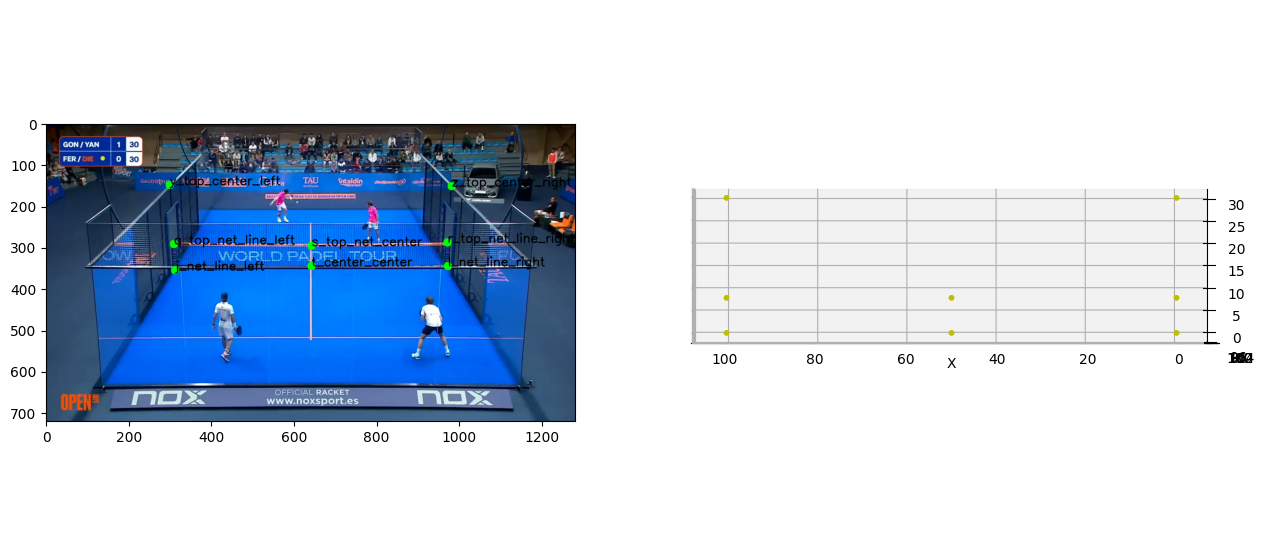

In [11]:
# Group points into common vertical planes (front wall, back wall, left wall, right wall, net)
net_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "net" in k or k in ["y_top_center_left", "z_top_center_right", "t_center_center"]
)
net_plane_world_dict = dict(
    (k, v)
    for k, v in corners_world_3d.items()
    if "net" in k or k in ["y_top_center_left", "z_top_center_right", "t_center_center"]
)

net_plane_world_points, net_plane_world_labels = dict_to_points(net_plane_world_dict)
net_plane_keypoints, net_plane_labels = dict_to_points(net_plane_dict)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), net_plane_keypoints, labels=net_plane_labels)
), plot_3d_points(
    x=net_plane_world_points[:, 0],
    y=net_plane_world_points[:, 1],
    z=net_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(0, 90, 0),
)

(<matplotlib.image.AxesImage at 0x2afb46fd0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

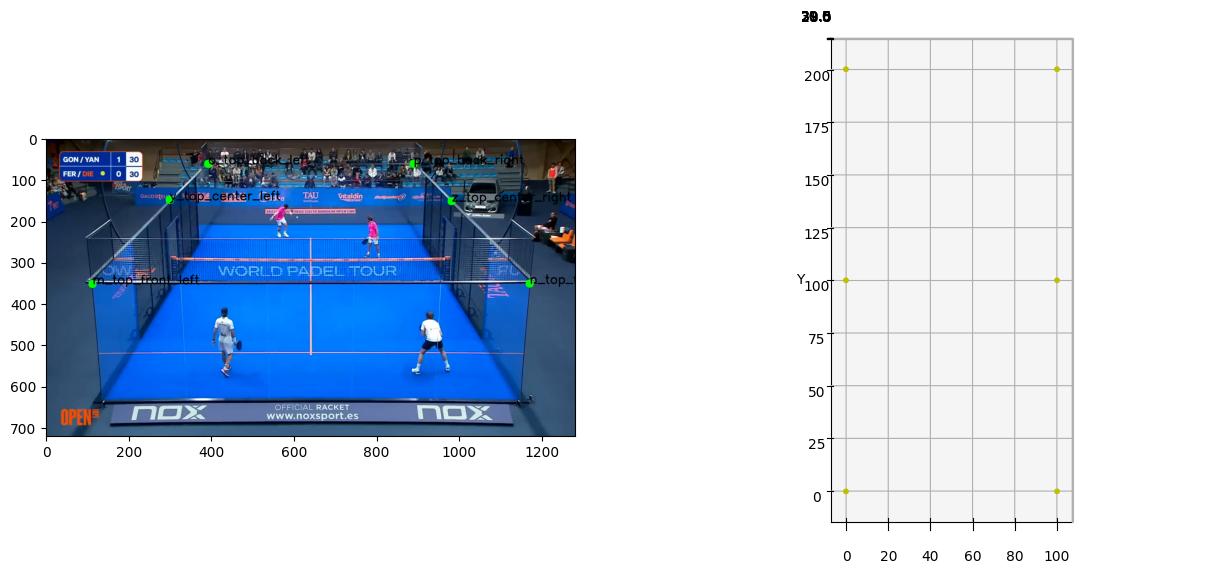

In [12]:
# Group points into common horizontal planes (top and topfence)
top_plane_dict = dict(
    (k, v)
    for k, v in keypoint_dict.items()
    if "top" in k and not "fence" in k and not "net" in k
)
top_plane_world_dict = dict(
    (k, v)
    for k, v in corners_world_3d.items()
    if "top" in k and not "fence" in k and not "net" in k
)
top_plane_world_points, top_plane_world_labels = dict_to_points(top_plane_world_dict)
top_plane_keypoints, top_plane_labels = dict_to_points(top_plane_dict)
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), top_plane_keypoints, labels=top_plane_labels)
), plot_3d_points(
    x=top_plane_world_points[:, 0],
    y=top_plane_world_points[:, 1],
    z=top_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(90, 0, 90),
)

(<matplotlib.image.AxesImage at 0x2afd872d0>,
 (<Axes3D: xlabel='X', ylabel='Y', zlabel='Z'>, None))

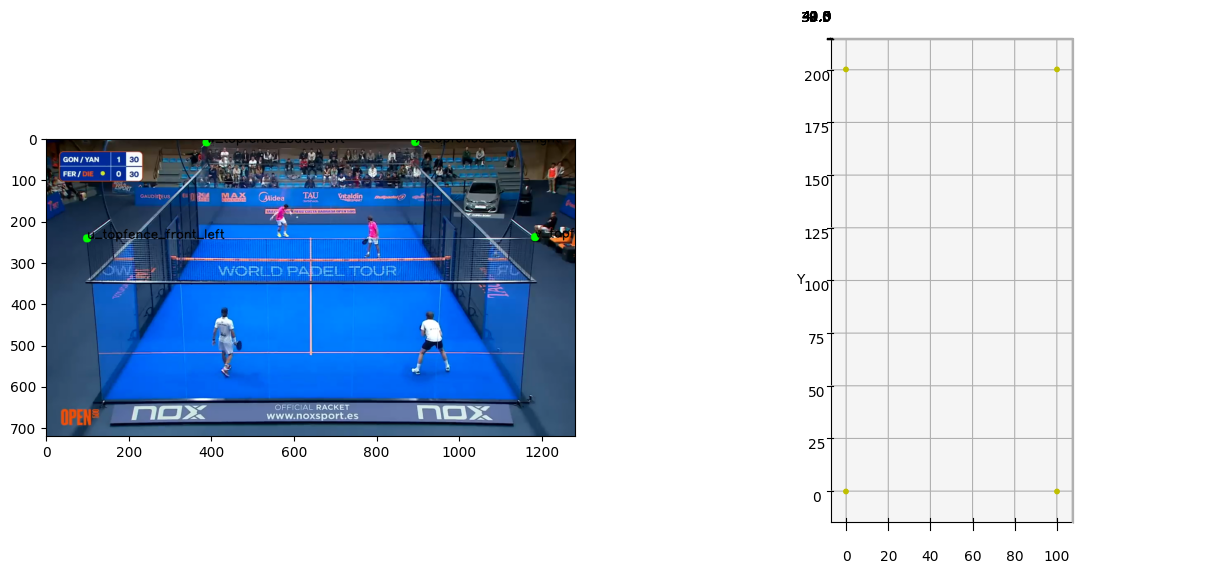

In [13]:
# Group points into common horizontal planes (top and topfence)
topfence_plane_dict = dict((k, v) for k, v in keypoint_dict.items() if "topfence" in k)
topfence_plane_world_dict = dict(
    (k, v) for k, v in corners_world_3d.items() if "topfence" in k
)

topfence_plane_world_points, topfence_plane_world_labels = dict_to_points(
    topfence_plane_world_dict
)

topfence_plane_keypoints, topfence_plane_labels = dict_to_points(topfence_plane_dict)

fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), topfence_plane_keypoints, labels=topfence_plane_labels)
), plot_3d_points(
    x=topfence_plane_world_points[:, 0],
    y=topfence_plane_world_points[:, 1],
    z=topfence_plane_world_points[:, 2],
    plt_axis=ax2,
    view_init=(90, 0, 90),
)

In [14]:
dd = 5
calibration_data = [
    (floor_plane_keypoints[:4], floor_plane_world_points[:4]),
    # (front_wall_plane_keypoints[:4], front_wall_plane_world_points[:4]),
    # (back_wall_plane_keypoints[:4], back_wall_plane_world_points[:4]),
    # # (left_wall_plane_keypoints[:4], left_wall_plane_world_points[:4]),
    # # (right_wall_plane_keypoints[:4], right_wall_plane_world_points[:4]),
    # (net_plane_keypoints[:4], net_plane_world_points[:4]),
    # (top_plane_keypoints[:4], top_plane_world_points[:4]),
    # (topfence_plane_keypoints, topfence_plane_world_points),
    # (floor_plane_keypoints, floor_plane_world_points), #8
    (front_wall_plane_keypoints, front_wall_plane_world_points),  # 0.8
    (back_wall_plane_keypoints, back_wall_plane_world_points),  # 0.3
    # (left_wall_plane_keypoints, left_wall_plane_world_points), # 8
    # (right_wall_plane_keypoints, right_wall_plane_world_points), # 9
    # (net_plane_keypoints, net_plane_world_points), # 3.2
    (top_plane_keypoints, top_plane_world_points),  # 0.02
    (topfence_plane_keypoints, topfence_plane_world_points),
]
repo_erro, camera_matrix, dist_coeffs, *_ = cv2.calibrateCamera(
    objectPoints=[convert_obj_points_to_planar(obj) for _, obj in calibration_data],
    imagePoints=[img for img, _ in calibration_data],
    imageSize=(image.shape[1], image.shape[0]),
    cameraMatrix=None,
    distCoeffs=None,
)
print(f"{repo_erro=}")

repo_erro=1.7614677782263706


success=True
reprojection_error=11.10609


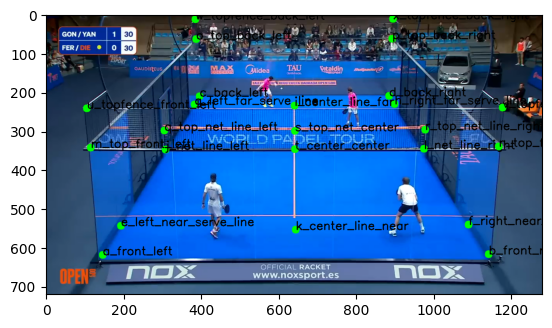

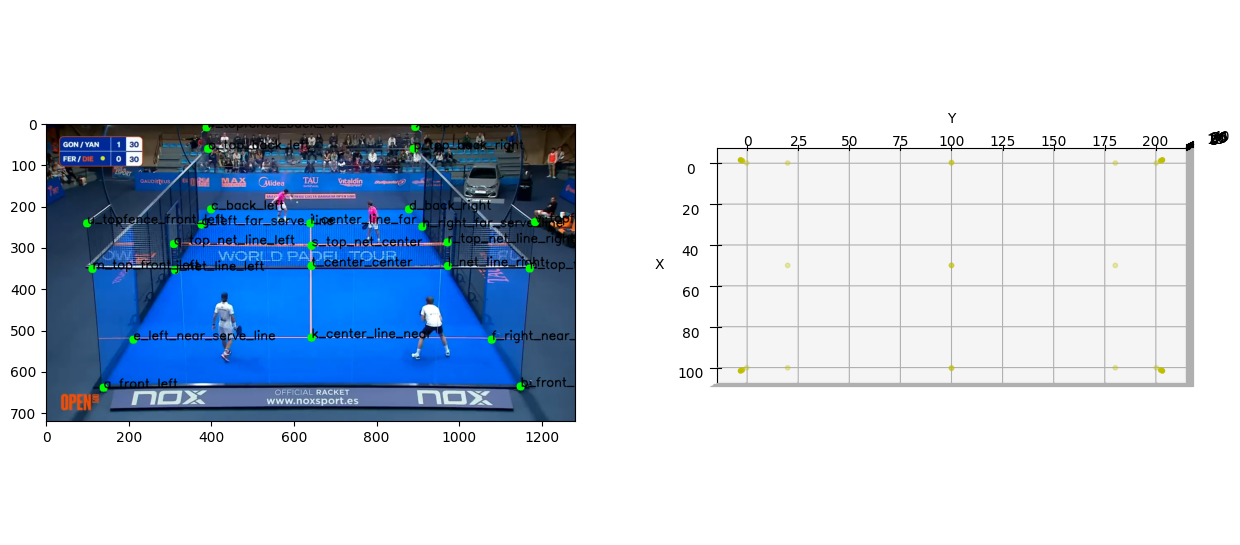

In [15]:
h, w = image.shape[:2]
optimal_camera_matrix, roi = cv2.getOptimalNewCameraMatrix(
    camera_matrix, dist_coeffs, (w, h), 1, (w, h), False
)

# dst = cv2.undistort(image, camera_matrix, dist_coeffs, None, optimal_camera_matrix)
# image_points_array_undist = np.array(
#     [
#         (x, y)
#         for x, y in cv2.undistortPoints(
#             image_points_array, camera_matrix, dist_coeffs, None, optimal_camera_matrix
#         ).squeeze()
#     ]
# )
num_pose_points = 24
success, rvec, tvec = cv2.solvePnP(
    world_points[:num_pose_points],
    keypoints[:num_pose_points],
    optimal_camera_matrix,
    dist_coeffs,
    # None,
    flags=cv2.SOLVEPNP_ITERATIVE,
    useExtrinsicGuess=False,
)


print(f"{success=}")
reprojected_image_points, _ = cv2.projectPoints(
    world_points[:num_pose_points],
    rvec,
    tvec,
    optimal_camera_matrix,
    dist_coeffs,
)
reprojected_image_points = reprojected_image_points.reshape(-1, 2)
reprojection_error = np.linalg.norm(
    reprojected_image_points[:num_pose_points] - keypoints[:num_pose_points], axis=1
).mean()
print(f"{reprojection_error=}")
plt.imshow(draw_points(image.copy(), reprojected_image_points, labels=labels))
fig = plt.figure(figsize=(15, 15))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222, projection="3d")
ax1.imshow(
    draw_points(image.copy(), keypoints[:num_pose_points], labels=labels)
), plot_3d_points(
    x=world_points[:num_pose_points, 0],
    y=world_points[:num_pose_points, 1],
    z=world_points[:num_pose_points, 2],
    plt_axis=ax2,
)

calibration_file_name = (
    CALIBRATION_DATA_PATH.parent
    / f"{num_pose_points}_error_{reprojection_error:.2f}_calibration"
)
np.savez(
    calibration_file_name,
    camera_matrix=camera_matrix,
    optimal_camera_matrix=optimal_camera_matrix,
    dist_coeffs=dist_coeffs,
    rotation_vector=rvec,
    translation_vector=tvec,
)

In [77]:
from scipy.spatial import transform

rotation_matrix, _ = cv2.Rodrigues(rvec)
# separate rotation and translation
# rotation_matrix = projection_matrix[:3, :3]
# rotation_matrix[:, 2] *= -1
# translation_xyz = projection_matrix[:3, 3]
# translation_xyz[2] *= -1
# translation_xyz[2] = -translation_xyz[2]
# convert rotation matrix to quaternion
# r = transform.Rotation.from_matrix(rotation_matrix)
r = transform.Rotation.from_rotvec(rvec.squeeze())
quat_xyzw = r.as_quat()
quat_xyzw

array([ 7.93183228e-01, -2.55252678e-04, -1.43752867e-03,  6.08981309e-01])

In [78]:
import rerun as rr


def log_court_layout(
    camera_matrix: np.array,
    image_width: int,
    image_height: int,
    translation_vector: np.array,
    rotation_vector: np.array,
    court_mesh_path: Path,
):
    rr.log_pinhole(
        "world/camera/image",
        child_from_parent=camera_matrix,
        width=image_width,
        height=image_height,
        timeless=True,
    )
    rotation_matrix, _ = cv2.Rodrigues(rotation_vector)
    rr.log_transform3d(
        "world/camera",
        transform=rr.TranslationAndMat3(
            translation=translation_vector.squeeze(),
            matrix=rotation_matrix,
        ),
        from_parent=True,
    )
    rr.log_mesh_file(
        "world",
        mesh_format=rr.MeshFormat("GLB"),
        mesh_path=court_mesh_path,
    )

In [132]:
rr.init("calibrate_camera", spawn=True)
rr.set_time_sequence("frame_nr", 0)
i = 0

In [144]:
rr.set_time_sequence("frame_nr", i)
i = i + 1
rr.log_pinhole(
    "world/camera/image",
    child_from_parent=optimal_camera_matrix,
    width=image.shape[1],
    height=image.shape[0],
)
rr.log_transform3d(
    "world/camera",
    transform=rr.TranslationAndMat3(
        translation=tvec.squeeze(),
        matrix=rotation_matrix,
    ),
    from_parent=True,
)
rr.log_image("world/camera/image", image)
rr.log_points("world", positions=world_points, labels=world_labels)
# rr.log_line_segments(
#     "world",
#     positions=world_points[:8] + world_points[9:11],
# )
rr.log_mesh_file(
    "world",
    #    transform=np.hstack([transform.Rotation.from_euler('zyx', [
    #             [0, 0, 0],
    #             [0, 90, 0],
    #             [0, 0, 90]], degrees=True
    #     ).apply(np.array([1.0, 1.0,1.0])), np.array([0,0,0]).reshape(3,1)]),
    mesh_format=rr.MeshFormat("GLB"),
    mesh_path=Path(
        "/Users/benjamindecharmoy/projects/courtvision/blender/basic_image.glb"
    ),
)
# rr.log_obb("world",
#            half_size=(0.5, 0.5, 0.5),
#            position=(0, 0, 0),
#            )

[2023-06-06T13:29:13Z WARN  re_renderer::importer::gltf] Textures on meshes are always sampled repeating address mode.
     exture None had ClampToEdge for s wrapping and ClampToEdge for t wrapping, these settings will be ignored


In [120]:
transform.Rotation.from_euler(
    "zyx", [[90, 0, 0], [0, 0, 0], [0, 0, 0]], degrees=True
).apply(np.array([1.0, 1.0, 1.0]))

array([[-1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.]])